In [31]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.models import Model
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K

In [2]:
train = pd.read_json('data/train/processed/train.json')
test = pd.read_json('data/test/processed/test.json')

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
print(train.shape, test.shape)
print(len(train['band_1'][0])) #75*75

(1604, 5) (8424, 4)
5625


In [5]:
train['band_1'] = train['band_1'].apply(lambda x: np.reshape(x, [75,75]))
train['band_2'] = train['band_2'].apply(lambda x: np.reshape(x, [75,75]))

In [6]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors = 'coerce')
train['inc_angle'] = train['inc_angle'].fillna(value = train['inc_angle'].mean())

In [7]:
def drawBands(band1, band2):
    band1 = np.reshape(band1, [75,75])
    band2 = np.reshape(band2, [75,75])
    plt.imshow(band1, interpolation = 'nearest')    
    plt.show()
    plt.imshow(band2, interpolation = 'nearest')
    plt.show()

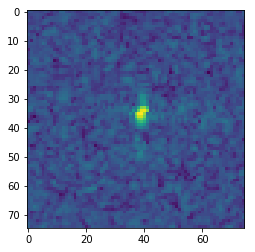

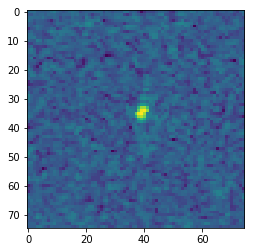

In [8]:
drawBands(train['band_1'][3], train['band_2'][3])

In [121]:
image_input = Input(shape = (75,75,2))
x = BatchNormalization(axis = -1, input_shape= [75,75,2])(image_input)
#CNN 0
x = Conv2D(filters = 32, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x) 
x = MaxPooling2D((2,2), strides = (1,1))(x)

#CNN 1
x = Conv2D(filters = 64, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x) 
x = MaxPooling2D((2,2))(x)

#CNN 2
x = Conv2D(filters = 128, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x) 
x = MaxPooling2D((2,2))(x)

#CNN 3
x = Conv2D(filters = 128, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x) 
x = MaxPooling2D((2,2))(x)

#CNN 4
x = Conv2D(filters = 64, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x) 
x = MaxPooling2D((2,2))(x)
x = Dropout(0.1)(x)

x = Flatten()(x)
inc_input = Input(shape = (1,)) #incidence angle
y = BatchNormalization(axis = -1)(inc_input)
x = Concatenate()([x,y])
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1, activation='sigmoid')(x)

In [122]:
dataInput = []
for i in train.index:
    dataInput.append(np.stack([train.loc[i]['band_1'], train.loc[i]['band_2']], axis = -1))
dataInput = np.array(dataInput)

In [123]:
np.random.seed(10)
indexTrain = np.random.choice(range(train.shape[0]), size = int(0.9*train.shape[0]), replace = False)
indexVal = list(set(range(train.shape[0])) - set(indexTrain))
dataInputTrain = dataInput[indexTrain]
dataInputVal = dataInput[indexVal]
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [124]:
model = Model(inputs = [image_input, inc_input], outputs= x)

In [125]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 75, 75, 2)    8           input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 73, 73, 32)   608         batch_normalization_105[0][0]    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 73, 73, 32)   128         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [126]:
model.compile(Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [127]:
def createGenerator( X, I, Y):
    while True:
        idx = np.random.permutation( X.shape[0])
        datagen = image.ImageDataGenerator( 
                                            rotation_range=20,
                                            height_shift_range=0.1,                                           
                                            horizontal_flip = True,
                                           vertical_flip = True, 
                                           width_shift_range=0.1,
                                            fill_mode='wrap',
                                          )
      

        batches = datagen.flow( X[idx], Y[idx], batch_size=64, shuffle=False)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], I[ idx[ idx0:idx1 ] ]], batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

In [128]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
mcp_save = ModelCheckpoint('weights/mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, epsilon=1e-4, mode='min')

In [129]:
model.fit_generator(createGenerator(X = dataInputTrain, I = traindf.inc_angle.values, Y = traindf.is_iceberg.values),
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values),
                    steps_per_epoch = len(traindf)/32, epochs = 2)

Epoch 1/2


/home/haoran/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1443, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


46/45 [==============================] - 16s 338ms/step - loss: 0.8710 - acc: 0.5202 - val_loss: 0.7064 - val_acc: 0.4783
Epoch 2/2
46/45 [==============================] - 12s 265ms/step - loss: 0.8067 - acc: 0.5456 - val_loss: 0.7615 - val_acc: 0.4783


In [130]:
K.set_value(model.optimizer.lr, 1e-2)
model.fit_generator(createGenerator(X = dataInputTrain, I = traindf.inc_angle.values, Y = traindf.is_iceberg.values),
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values),
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                   steps_per_epoch = len(traindf)/32, epochs = 200)

Epoch 1/200


/home/haoran/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1443, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


46/45 [==============================] - 17s 363ms/step - loss: 0.6287 - acc: 0.6880 - val_loss: 7.7087 - val_acc: 0.5217
Epoch 2/200
46/45 [==============================] - 12s 268ms/step - loss: 0.4493 - acc: 0.7832 - val_loss: 2.8399 - val_acc: 0.5280
Epoch 3/200
46/45 [==============================] - 12s 269ms/step - loss: 0.3961 - acc: 0.8127 - val_loss: 0.5917 - val_acc: 0.7888
Epoch 4/200
46/45 [==============================] - 13s 276ms/step - loss: 0.3345 - acc: 0.8448 - val_loss: 0.6040 - val_acc: 0.7826
Epoch 5/200
46/45 [==============================] - 12s 266ms/step - loss: 0.3385 - acc: 0.8436 - val_loss: 0.7053 - val_acc: 0.7826
Epoch 6/200
46/45 [==============================] - 12s 268ms/step - loss: 0.3100 - acc: 0.8633 - val_loss: 0.5787 - val_acc: 0.7888
Epoch 7/200
46/45 [==============================] - 12s 270ms/step - loss: 0.2857 - acc: 0.8789 - val_loss: 0.3553 - val_acc: 0.8758
Epoch 8/200
46/45 [==============================] - 12s 268ms/step - loss